# Sentinel-2-Landkreise
Abrufen der Sentinel-2-Landkreise vom [CODE-DE](www.code-de.org)-Cloud-Speicher

## Imports

In [ ]:
%pip install -r requirements.txt

In [1]:
import geopandas as gpd
import sys
from tqdm import tqdm
sys.path.append('app')
import functions
from config import settings

## Gebiet festlegen

In [2]:
area_name = 'Niedersachsen' # oder z.B.: 'Deutschland', 'Niedersachsen', 'Oldenburg', ...

## Landkreise darstellen

In [3]:
name, be_name, area, tiles = functions.load_tiles(area=area_name)
area.explore(tooltip=None, popup=True)

/opt/tljh/user/envs/sentinel2l/lib/python3.11/site-packages/geopandas/geodataframe.py:2323: UserWarning: `keep_geom_type=True` in overlay resulted in 19 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(
/home/jupyter-jonas/opencode-test/sentinel2l/app/functions.py:122: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  selected_tiles = max_tiles.append(rest_tiles)


## Einzelnen Sentinel-2-Landkreis per URL abrufen

In [4]:
landkreis_name = 'Region-Hannover'

In [5]:
# endpoint_url = 'https://cloud.code-de.org:8080/swift/v1/AUTH_622a231224cb46c6982643e55e817c98/'
endpoint_url = settings.COS_PUB_URL

#bucket_name = 'sentinel-2-landkreise'
bucket_name = settings.LANDKREISE_BUCKET

datum = '20200921'
datensatz = 'S2'

dateiname = f'{landkreis_name}_{datum}_{datensatz}.tif'
url = endpoint_url + f'{bucket_name}/{dateiname}'

print(f'Download-URL: \n{url}')

Download-URL: 
https://cloud.code-de.org:8080/swift/v1/AUTH_622a231224cb46c6982643e55e817c98/sentinel-2-landkreise/Region-Hannover_20200921_S2.tif


## Dateinamen für weitere Daten per URL anzeigen

### Alle Daten für den Landkreis:

In [6]:
endpoint_url + bucket_name + f'/?prefix={landkreis_name}'

'https://cloud.code-de.org:8080/swift/v1/AUTH_622a231224cb46c6982643e55e817c98/sentinel-2-landkreise/?prefix=Region-Hannover'

### Daten für einen Zeitraum:

In [7]:
date = '2021'
endpoint_url + bucket_name + f'/?prefix={landkreis_name}_{date}'

'https://cloud.code-de.org:8080/swift/v1/AUTH_622a231224cb46c6982643e55e817c98/sentinel-2-landkreise/?prefix=Region-Hannover_2021'

## Sentinel-2-Landkreis anzeigen

In [8]:
import rasterio
from rasterio.plot import show, plotting_extent
import matplotlib.pyplot as plt
import numpy as np

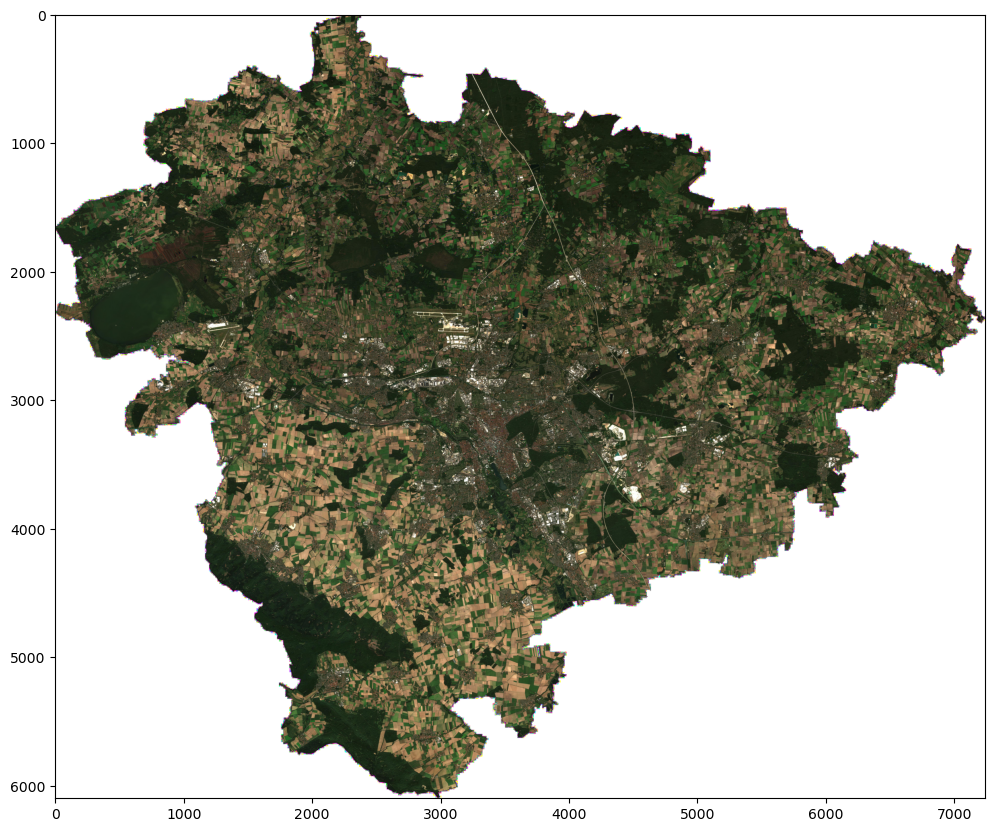

In [9]:
with rasterio.open(url) as image:
    image_data = image.read()
    image_data[image_data==0] = np.max(image_data) # transparenter hintergrund
    image_extend = plotting_extent(image) # wird für den nächsten Plot benötigt
    plt.figure(figsize=(12, 12))    
    show(image_data)

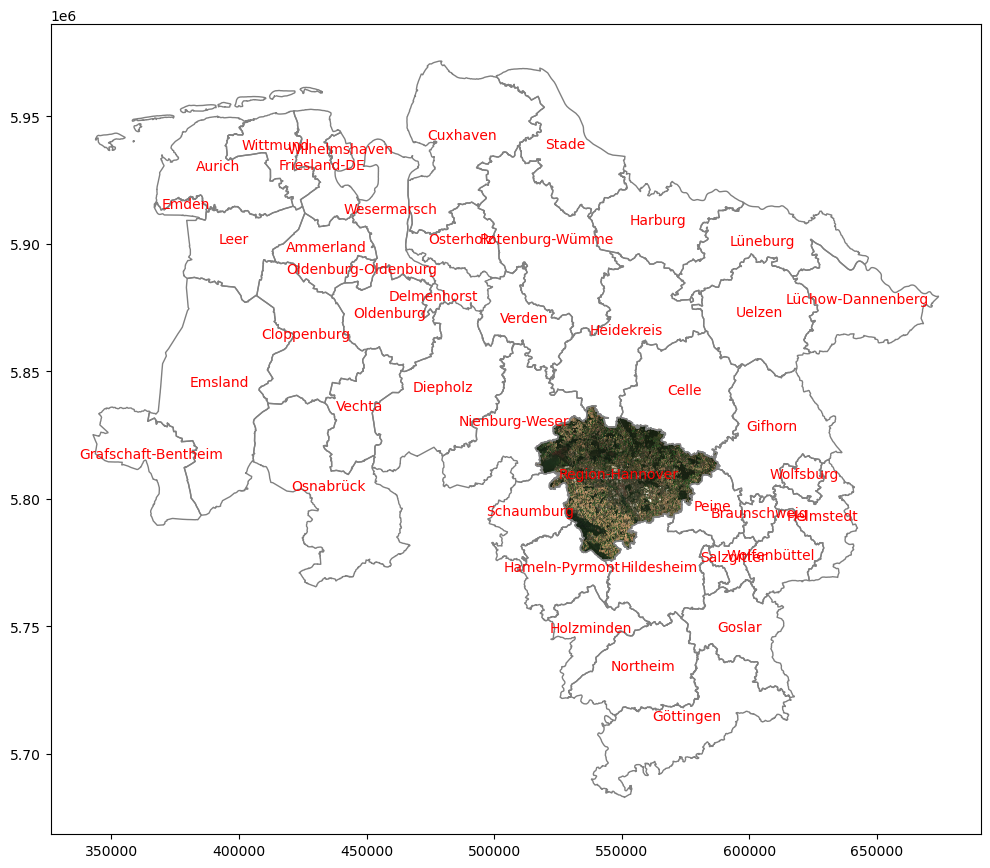

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))
rasterio.plot.show(image_data, ax=ax, extent=image_extend)
area.plot(ax=ax, legend=True, edgecolor='gray', facecolor='none')
area.apply(lambda x: ax.annotate(text=x.nuts3_simple_name	, 
                                 xy=x.geometry.centroid.coords[0], 
                                 ha='center', color='red', 
                                 fontsize='medium'), 
                                 axis=1);

## Anzahl der Sentinel-2-Landkreise visualisieren

In [11]:
from tqdm import tqdm
import requests

date = "2022"

landkreise = area.nuts3_simple_name.to_list()

for landkreis in tqdm(landkreise):

    request_url = settings.COS_PUB_URL + settings.LANDKREISE_BUCKET + f'/?prefix={landkreis}_{date}'
    response = requests.get(request_url)
    files = response.content.decode().split('\n')
    tifs = [s for s in files if "S2.tif" in s] # count only S2.tif, not NDVI.tif or .json

    area.loc[area['nuts3_simple_name'] == landkreis, 'image_count'] = len(tifs)

area[(area.nuts3_simple_name.isin(landkreise))]

100%|██████████| 44/44 [00:02<00:00, 18.73it/s]


nuts3_simple_name                               nuts3_name  \
10             Ammerland                                Ammerland   
15                Aurich                                   Aurich   
38          Braunschweig           Braunschweig, Kreisfreie Stadt   
46                 Celle                                    Celle   
49           Cloppenburg                              Cloppenburg   
54              Cuxhaven                                 Cuxhaven   
60           Delmenhorst            Delmenhorst, Kreisfreie Stadt   
62              Diepholz                                 Diepholz   
79                 Emden                  Emden, Kreisfreie Stadt   
81               Emsland                                  Emsland   
101         Friesland-DE                           Friesland (DE)   
110              Gifhorn                                  Gifhorn   
111               Goslar                                   Goslar   
113  Grafschaft-Bentheim                      Grafschaft Bentheim   
118            Göttingen                                Göttingen   
124       Hameln-Pyrmont                           Hameln-Pyrmont   
126              Harburg                                  Harburg   
130           Heidekreis                               Heidekreis   
135            Helmstedt                                Helmstedt   
141           Hildesheim                               Hildesheim   
146           Holzminden                               Holzminden   
174                 Leer                                     Leer   
186    Lüchow-Dannenberg                        Lüchow-Dannenberg   
187             Lüneburg                      Lüneburg, Landkreis   
225       Nienburg-Weser                         Nienburg (Weser)   
230             Northeim                                 Northeim   
242            Oldenburg                     Oldenburg, Landkreis   
243  Oldenburg-Oldenburg  Oldenburg (Oldenburg), Kreisfreie Stadt   
246            Osnabrück              Osnabrück, Kreisfreie Stadt   
249            Osterholz                                Osterholz   
254                Peine                                    Peine   
268      Region-Hannover                          Region Hannover   
286      Rotenburg-Wümme                        Rotenburg (Wümme)   
296           Salzgitter             Salzgitter, Kreisfreie Stadt   
298           Schaumburg                               Schaumburg   
317                Stade                                    Stade   
340               Uelzen                                   Uelzen   
345               Vechta                                   Vechta   
346               Verden                                   Verden   
364          Wesermarsch                              Wesermarsch   
368        Wilhelmshaven          Wilhelmshaven, Kreisfreie Stadt   
370             Wittmund                                 Wittmund   
371         Wolfenbüttel                             Wolfenbüttel   
372            Wolfsburg              Wolfsburg, Kreisfreie Stadt   

        nuts1_name     nuts3_no_umlaute  \
10   Niedersachsen            Ammerland   
15   Niedersachsen               Aurich   
38   Niedersachsen         Braunschweig   
46   Niedersachsen                Celle   
49   Niedersachsen          Cloppenburg   
54   Niedersachsen             Cuxhaven   
60   Niedersachsen          Delmenhorst   
62   Niedersachsen             Diepholz   
79   Niedersachsen                Emden   
81   Niedersachsen              Emsland   
101  Niedersachsen         Friesland-DE   
110  Niedersachsen              Gifhorn   
111  Niedersachsen               Goslar   
113  Niedersachsen  Grafschaft-Bentheim   
118  Niedersachsen           Goettingen   
124  Niedersachsen       Hameln-Pyrmont   
126  Niedersachsen              Harburg   
130  Niedersachsen           Heidekreis   
135  Niedersachsen            Helmstedt   
141  Niedersachsen           Hildesheim  

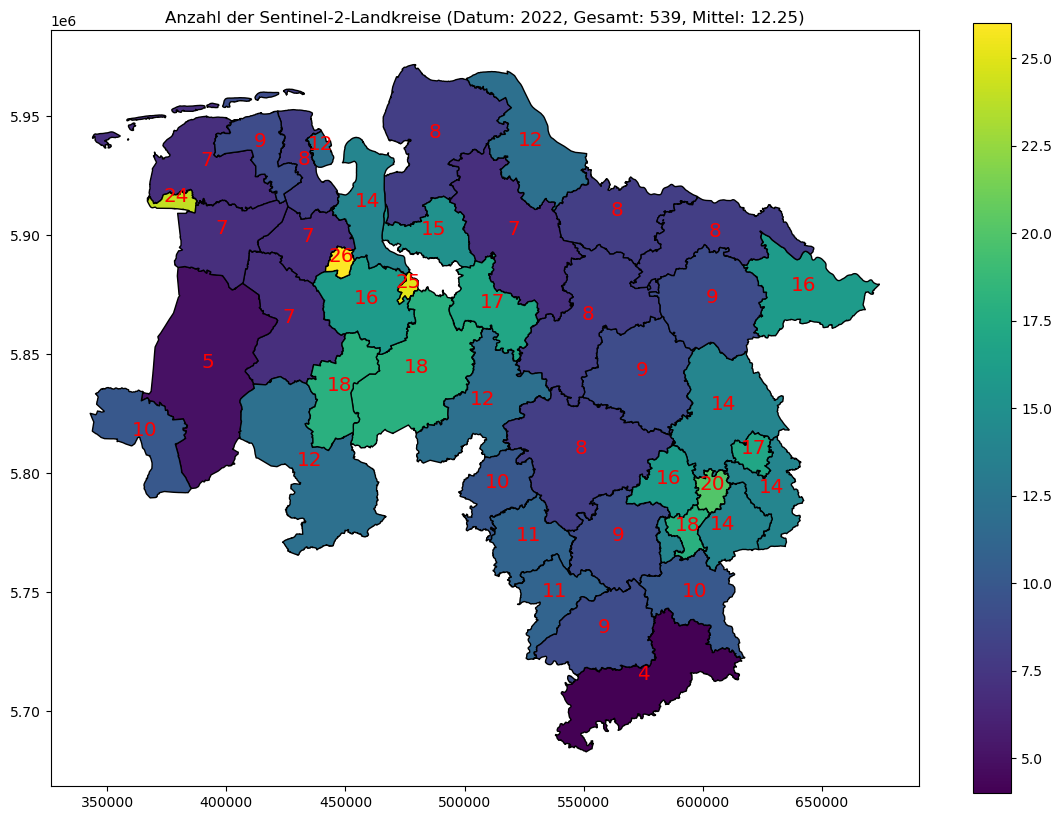

In [12]:
anzahl = area['image_count'].sum()
mittel = area['image_count'].mean()  

ax = area.plot(column='image_count', figsize=(14, 10), legend=True, edgecolor='black')
ax.set(title=f'Anzahl der Sentinel-2-Landkreise (Datum: {date}, Gesamt: {int(anzahl)}, Mittel: {mittel:.2f})')
area.apply(lambda x: ax.annotate(text=int(x.image_count), xy=x.geometry.centroid.coords[0], ha='center', color='red', fontsize='x-large'), axis=1);